In [1]:
# Remove the unnecessary print statement for library imports
print("Importing necessary libraries...")

import datetime
import gc
import re
import string
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import psutil

from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras_tuner as kt

from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords

# Example of using English stopwords
stop_words = stopwords.words('english')

outputDir = 'C:\\Users\\Owner\\OneDrive\\Desktop\\My Computer\\AI\\Master of Science in Artificial Intelligence [Taught and Research (Mainly by Research)]\\ICS5200 Dissertation\\Result Screenshots\\Subplots\\'

start = datetime.datetime.now()

label_encoder = LabelEncoder()

Importing necessary libraries...


In [2]:
%%time

dataset = pd.read_csv("./Datasets/train.csv",encoding='latin1')

print("Compiling final dataset...", end =" "),
dataset = dataset[['text', 'sentiment']]
print("done!")

dataset = dataset.dropna(subset=['text'])
dataset = dataset.dropna(subset=['sentiment'])

# Strip leading and trailing whitespace from the text column
dataset['text'] = dataset['text'].str.strip()

difference = 7000
# difference = 9000

# Calculating extra rows to be removed.
posDiff = (dataset[dataset.sentiment == 'positive'].shape[0]) - difference
negDiff = (dataset[dataset.sentiment == 'negative'].shape[0]) - difference
neuDiff = (dataset[dataset.sentiment == 'neutral'].shape[0]) - difference

print("Twitter Neutral Sentiment entries : ", dataset[dataset.sentiment == 'neutral'].shape[0], " rows, with ", neuDiff, " rows to remove.")
print("Twitter Positive Sentiment entries: ", dataset[dataset.sentiment == 'positive'].shape[0], "rows, with ", posDiff, " rows to remove.")
print("Twitter Negative Sentiment entries: ", dataset[dataset.sentiment == 'negative'].shape[0], "rows, with ", negDiff, " rows to remove.")

# Function to drop rows based on sorted index
def drop_excess_rows(df, sentiment, excess_count):
    if excess_count > 0:
        # Sort the DataFrame by index
        sorted_df = df[df['sentiment'] == sentiment].sort_index()
        # Drop the excess rows
        df = df.drop(sorted_df.index[:excess_count])
    return df

# Remove extra rows for each sentiment category
dataset = drop_excess_rows(dataset, 'neutral', neuDiff)
dataset = drop_excess_rows(dataset, 'positive', posDiff)
dataset = drop_excess_rows(dataset, 'negative', negDiff)

print("Updated Twitter Neutral Sentiment entries : ", dataset[dataset.sentiment == 'neutral'].shape[0])
print("Updated Twitter Positive Sentiment entries: ", dataset[dataset.sentiment == 'positive'].shape[0])
print("Updated Twitter Negative Sentiment entries: ", dataset[dataset.sentiment == 'negative'].shape[0])

X = dataset['text']
y = dataset['sentiment']

# Simple text preprocessing function
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lowercase
    text = text.lower()
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = text.strip()
    return text

# Apply preprocessing to each text entry
X = X.apply(preprocess_text)

Compiling final dataset... done!
Twitter Neutral Sentiment entries :  11117  rows, with  4117  rows to remove.
Twitter Positive Sentiment entries:  8582 rows, with  1582  rows to remove.
Twitter Negative Sentiment entries:  7781 rows, with  781  rows to remove.
Updated Twitter Neutral Sentiment entries :  7000
Updated Twitter Positive Sentiment entries:  7000
Updated Twitter Negative Sentiment entries:  7000
CPU times: total: 31.2 ms
Wall time: 129 ms


In [3]:
%%time

# X = dataset['text']
# y = dataset['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train)

# Transform the test data
X_test_cv = cv.transform(X_test)

# Define models
svm_model = SVC(probability=True)
nb_model = MultinomialNB()
lr_model = LogisticRegression()
dt_model = DecisionTreeClassifier()

# Voting classifier
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('nb', nb_model),
    ('lr', lr_model),
    ('dt', dt_model)
], voting='soft')

# Fit models
models = [svm_model, nb_model, lr_model, dt_model]
model_names = ['SVM', 'Naive Bayes', 'Logistic Regression', 'Decision Tree']

for model, name in zip(models, model_names):
    print(f"Training {name} model...", end = "")
    model.fit(X_train_cv, y_train)
    print(f"Done training {name} model.")

print("Fitting Voting Classifier...", end = "")
voting_clf.fit(X_train_cv, y_train)
print("Voting Classifier trained.")

print("\nClassification report for Voting Classifier:")
voting_preds = voting_clf.predict(X_test_cv)
print(classification_report(y_test, voting_preds))

Training SVM model...Done training SVM model.
Training Naive Bayes model...Done training Naive Bayes model.
Training Logistic Regression model...

D:\Anaconda Download\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done training Logistic Regression model.
Training Decision Tree model...Done training Decision Tree model.
Fitting Voting Classifier...

D:\Anaconda Download\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier trained.

Classification report for Voting Classifier:
              precision    recall  f1-score   support

    negative       0.69      0.72      0.71      1392
     neutral       0.59      0.60      0.59      1370
    positive       0.77      0.73      0.75      1438

    accuracy                           0.68      4200
   macro avg       0.68      0.68      0.68      4200
weighted avg       0.69      0.68      0.68      4200

CPU times: total: 2min 28s
Wall time: 5min 51s


In [4]:
X = dataset['text']
y = dataset['sentiment']

# Preprocessing function
def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

# Apply preprocessing
X = X.apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust the max_features as needed
X_train_vec = vectorizer.fit_transform(X_train.values.astype('U')).toarray()
X_test_vec = vectorizer.transform(X_test.values.astype('U')).toarray()

# Reshape data for LSTM
max_features = X_train_vec.shape[1]

X_train_lstm = X_train_vec.reshape(X_train_vec.shape[0], 1, max_features)
X_test_lstm = X_test_vec.reshape(X_test_vec.shape[0], 1, max_features)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Define the LSTM model with batch normalization and regularization
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=False, input_shape=(1, max_features), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
lstm_model.add(Dropout(0.5)),
lstm_model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))),
lstm_model.add(Dropout(0.5)),
lstm_model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))),
lstm_model.add(Dropout(0.5)),
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(3, activation='softmax'))

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
lstm_model.summary()

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and model checkpoint
history = lstm_model.fit(X_train_lstm, y_train_onehot, batch_size=100, epochs=20, validation_split=0.1, callbacks=[early_stopping])

print("Predicting with LSTM model...", end=" ")

# Predict on the test set
lstm_preds = lstm_model.predict(X_test_lstm).argmax(axis=1)  # Get the class with highest probability

# Extract precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, lstm_preds, average=None)

# Generate the classification report
class_report = classification_report(y_test, lstm_preds, target_names=label_encoder.classes_)
print(class_report)

D:\Anaconda Download\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │       5,186,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,196,611 (19.82 MB)

 Trainable params: 5,196,547 (19.82 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3696 - loss: 4.0103 - val_accuracy: 0.3280 - val_loss: 1.3076
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5081 - loss: 1.1809 - val_accuracy: 0.4643 - val_loss: 1.2543
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5600 - loss: 1.1167 - val_accuracy: 0.5923 - val_loss: 1.1658
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5993 - loss: 1.0707 - val_accuracy: 0.6220 - val_loss: 1.0971
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6052 - loss: 1.0634 - val_accuracy: 0.6470 - val_loss: 1.0155
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6203 - loss: 1.0374 - val_accuracy: 0.6631 - val_loss: 0.9907
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6078 - loss: 1.0515 - val_accuracy: 0.6512 - val_loss: 0.9926
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6338 - loss: 1.0224 - val_accu

In [5]:
%%time

# Artificial Neural Network (ANN) Model
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.values.astype('U')).toarray()
X_test_vec = vectorizer.transform(X_test.values.astype('U')).toarray()

ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(X_train_vec.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

ann_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

ann_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = ann_model.fit(X_train_vec, y_train, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stopping])


print("Predicting with ANN model...", end = " ")
ann_preds = ann_model.predict(X_test_vec).argmax(axis=1)

# Extract precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, ann_preds, average=None)

# Generate the classification report
class_report = classification_report(y_test, ann_preds, target_names=label_encoder.classes_)
print(class_report)

D:\Anaconda Download\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │       2,601,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,601,987 (9.93 MB)

 Trainable params: 2,601,731 (9.92 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4019 - loss: 1.2138 - val_accuracy: 0.6262 - val_loss: 1.0993
Epoch 2/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6870 - loss: 0.8316 - val_accuracy: 0.6649 - val_loss: 0.9678
Epoch 3/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7897 - loss: 0.6491 - val_accuracy: 0.6780 - val_loss: 0.8050
Epoch 4/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8490 - loss: 0.5233 - val_accuracy: 0.6774 - val_loss: 0.7759
Epoch 5/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8878 - loss: 0.4365 - val_accuracy: 0.6720 - val_loss: 0.7860
Epoch 6/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9116 - loss: 0.3744 - val_accuracy: 0.6714 - val_loss: 0.8010
Epoch 7/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9276 - loss: 0.3235 - val_accuracy: 0.6679 - val_loss: 0.8194
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

    nega

Target names: ['negative' 'positive' 'neutral']
Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.75      0.70      1445
    positive       0.59      0.51      0.55      1379
     neutral       0.78      0.74      0.76      1376

    accuracy                           0.67      4200
   macro avg       0.67      0.67      0.67      4200
weighted avg       0.67      0.67      0.67      4200



D:\Anaconda Download\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
D:\Anaconda Download\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
D:\Anaconda Download\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CPU Load     :  2.4
RAM Used (GB): 17.759875072


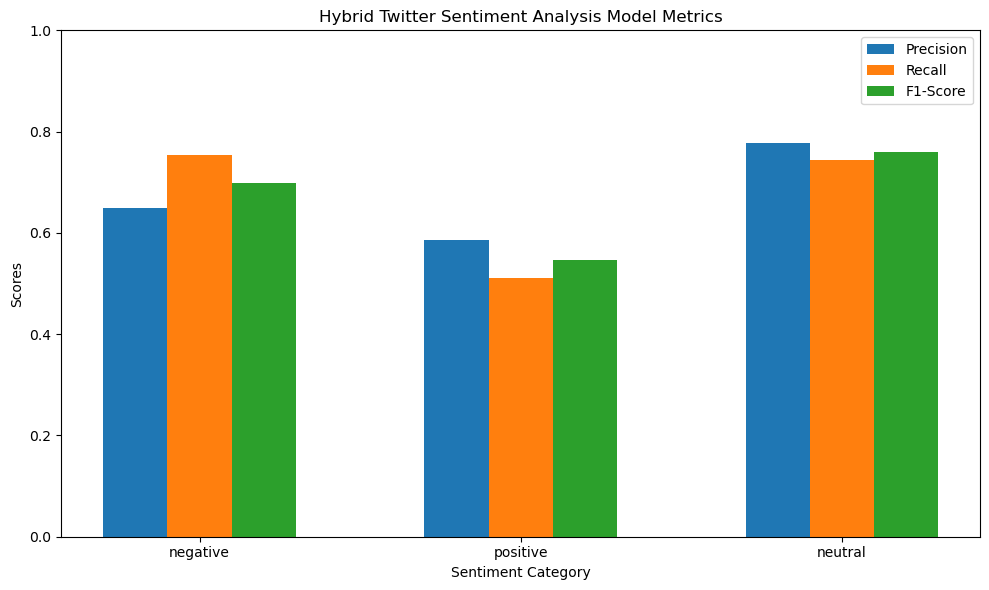


Total program execution time: 0:07:14.215689
CPU times: total: 422 ms
Wall time: 1.64 s


4099

In [6]:
%%time

# Function to convert class labels to one-hot encoded probabilities
def to_one_hot(labels, num_classes):
    encoder = OneHotEncoder(categories='auto', sparse=False)
    # Reshape the labels to (num_samples, 1) and fit_transform to get one-hot encoded form
    labels_one_hot = encoder.fit_transform(labels.reshape(-1, 1))
    # Ensure the output shape matches the number of classes
    if labels_one_hot.shape[1] != num_classes:
        raise ValueError(f"Number of classes mismatch: expected {num_classes}, got {labels_one_hot.shape[1]}")
    return labels_one_hot

# Convert lstm_preds and ann_preds to one-hot encoded form
voting_probs = to_one_hot(voting_preds, 3)
lstm_probs = to_one_hot(lstm_preds, 3)
ann_probs = to_one_hot(ann_preds, 3)

# Combine the predictions correctly by averaging
avg_preds = (voting_probs + lstm_probs + ann_probs) / 3

# Final predictions
final_preds = np.argmax(avg_preds, axis=1)

# Check target names consistency
if isinstance(y_test[0], str):
    target_names = label_encoder.classes_
else:
    target_names = dataset['sentiment'].unique()

# Generate classification report
print("Target names:", target_names)
print("Classification Report:")
class_report = classification_report(y_test, final_preds, target_names=target_names)
print(class_report)

print("CPU Load     : ", psutil.cpu_percent(1))
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

# Plotting metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, final_preds, average=None)
labels = dataset['sentiment'].unique()

plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(np.arange(len(labels)), precision, width=bar_width, label='Precision', align='center')
plt.bar(np.arange(len(labels)) + bar_width, recall, width=bar_width, label='Recall', align='center')
plt.bar(np.arange(len(labels)) + bar_width * 2, f1, width=bar_width, label='F1-Score', align='center')

plt.xlabel('Sentiment Category')
plt.ylabel('Scores')
plt.title('Hybrid Twitter Sentiment Analysis Model Metrics')
plt.xticks(np.arange(len(labels)) + bar_width, labels)
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()

# Saving plot
plt.savefig(outputDir + '\\Hybrid\\HybridModelTwitter.png')
plt.show()

# Execution time
end = datetime.datetime.now()
duration = end - start
print("\nTotal program execution time:", duration)

# Garbage collection
gc.collect()